In [1]:
from dataclasses import dataclass
from typing import Iterable, Optional, List
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np

pl.style.use(
    'https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle'
)


@dataclass
class Record:
    obj_id: int
    time: float
    lat: float
    lon: float
    alt: float
    pitch: float
    roll: float
    yaw: float
    u: float
    v: float
    heading: float


def parse_timestamp(line: str) -> float:
    return float(line.strip()[1:])


fields_simple = {'lon': 0, 'lat': 1, 'alt': 2, 'u': 3, 'v': 4}

fields_complex = {
    'lon': 0,
    'lat': 1,
    'alt': 2,
    'roll': 3,
    'pitch': 4,
    'yaw': 5,
    'u': 6,
    'v': 7,
    'heading': 8
}


def parse_record(obj_id: int, t: float, entries: List[str],
                 last: Optional[Record], field_order_map: dict) -> Record:

    def take_value_from_last_record(field_name):
        if last is None:
            return 0.0
        return getattr(last, field_name)

    def parse_entry(field_name, idx):
        entry = entries[idx].strip()
        if len(entry) == 0:
            return take_value_from_last_record(field_name)
        return float(entry)

    d = {}
    for field in fields_complex:
        if field not in field_order_map:
            d[field] = take_value_from_last_record(field)
            continue
        idx = field_order_map[field]
        val = parse_entry(field, idx)
        d[field] = val
    d['obj_id'] = obj_id
    d['time'] = t

    r = Record(**d)
    return r


def parse_simple(obj_id: int, t: float, fields: List[str],
                 last: Optional[Record]) -> Record:
    return parse_record(obj_id, t, fields, last, fields_simple)


def parse_complex(obj_id: int, t: float, fields: List[str],
                  last: Optional[Record]) -> Record:
    return parse_record(obj_id, t, fields, last, fields_complex)


def parse_transform_line(obj_id: int,
                         t: float,
                         line: str,
                         last: Optional[Record] = None) -> Record:
    assert (line[:2] == 'T=')
    line = line[2:]
    fields = line.split('|')
    if len(fields) == 5:
        return parse_simple(obj_id, t, fields, last)
    elif len(fields) == 9:
        return parse_complex(obj_id, t, fields, last)
    else:
        assert (False)


def load_from_tacview(filename: str, obj_ids: Iterable[int]):
    t = 0.0
    d = {obj_id: [] for obj_id in obj_ids}
    with open(filename) as f:
        for _ in range(7):
            f.readline()
        for line in f:
            if line.startswith("#"):
                t = parse_timestamp(line)
                continue
            tokens = line.split(',')

            obj_id = int(tokens[0], 16)
            if obj_id not in obj_ids:
                continue
            last = None if len(d[obj_id]) == 0 else d[obj_id][-1]
            result = parse_transform_line(obj_id, t, tokens[1], last=last)
            d[obj_id].append(result)
        return d

def to_dataframe(record_array):
    return pd.DataFrame([vars(record) for record in record_array])


TARGET_ID = 0xFF00014D92
MISSILE_ID = 0x3e800008FEE


d = load_from_tacview('uoaf-582.txt.acmi', [TARGET_ID, MISSILE_ID])

tgt_data = to_dataframe(d[TARGET_ID])
missile_data = to_dataframe(d[MISSILE_ID])
t0 = missile_data['time'][0]
tgt_data['time'] -= t0
missile_data['time'] -= t0


tgt_data = tgt_data[(tgt_data['time'] > missile_data['time'].min()) & (tgt_data['time'] < missile_data['time'].max())]

tgt_data = tgt_data.set_index('time')
missile_data = missile_data.set_index('time')
tgt = tgt_data.reindex(tgt_data.index.union(missile_data.index)).sort_index(ascending=True).interpolate(method='index')
msl = missile_data.reindex(missile_data.index.union(tgt_data.index)).sort_index(ascending=True).interpolate(method='index')
tgt = tgt.reset_index()[3:]
msl = msl.reset_index()[3:]

(0.0, 10.0)

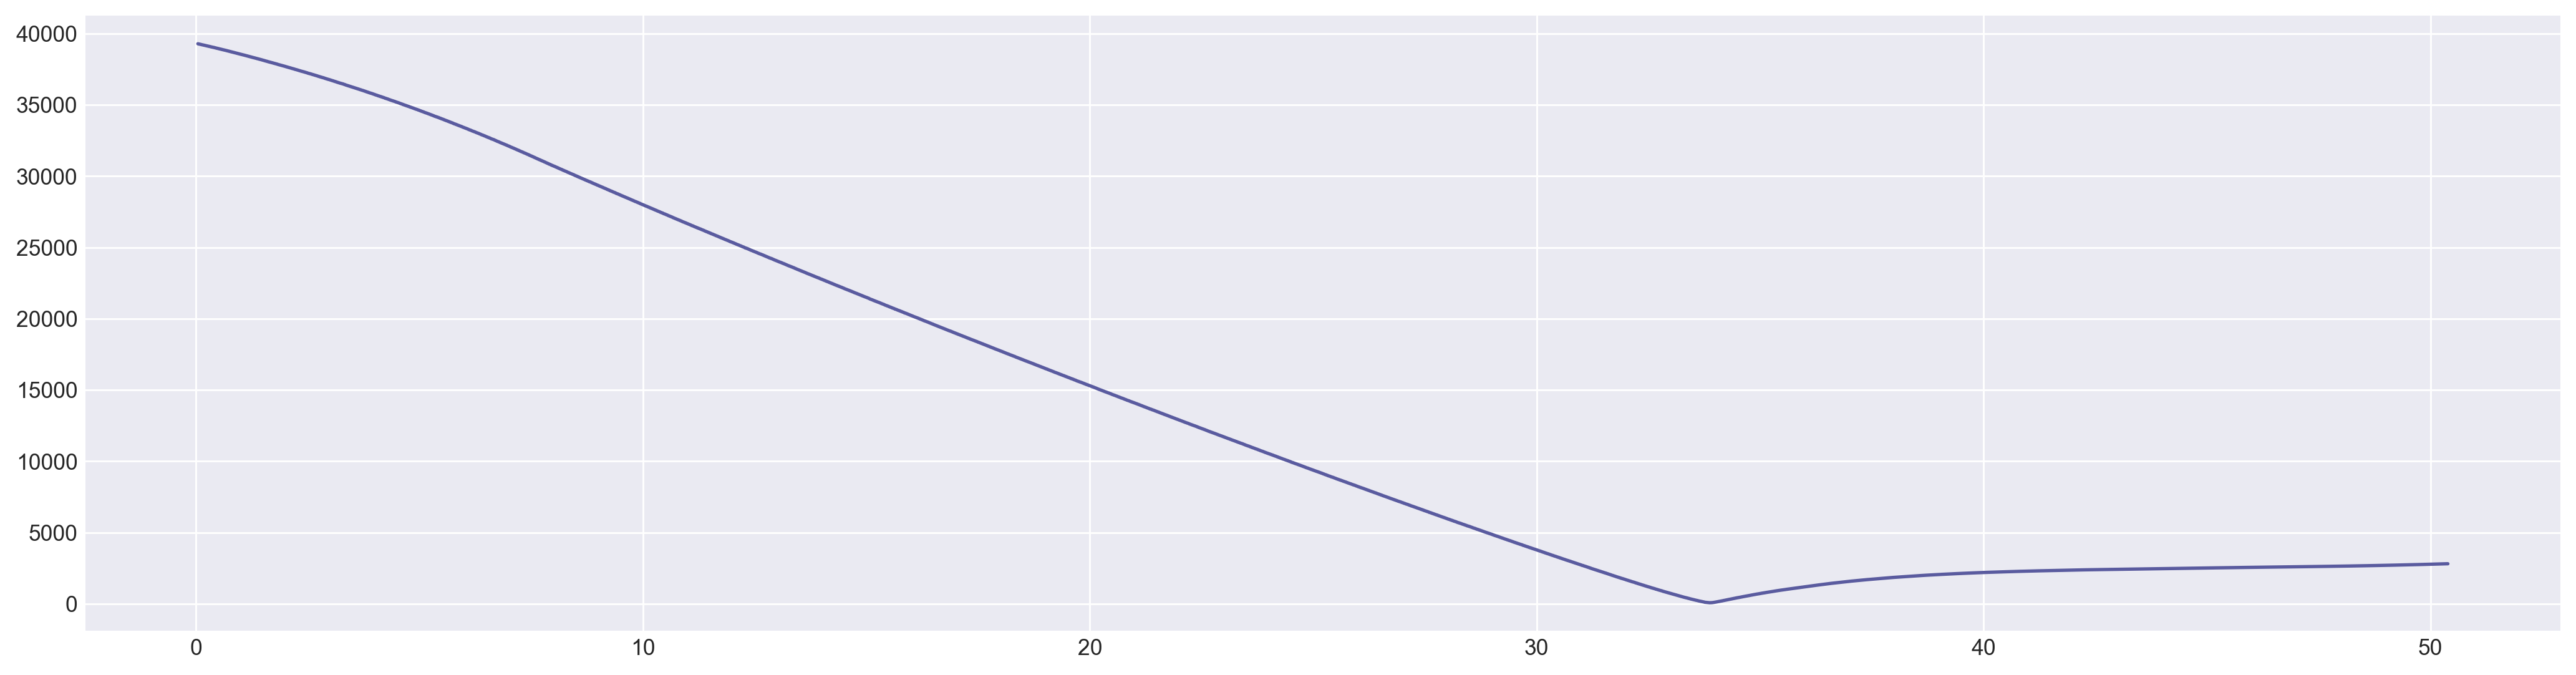

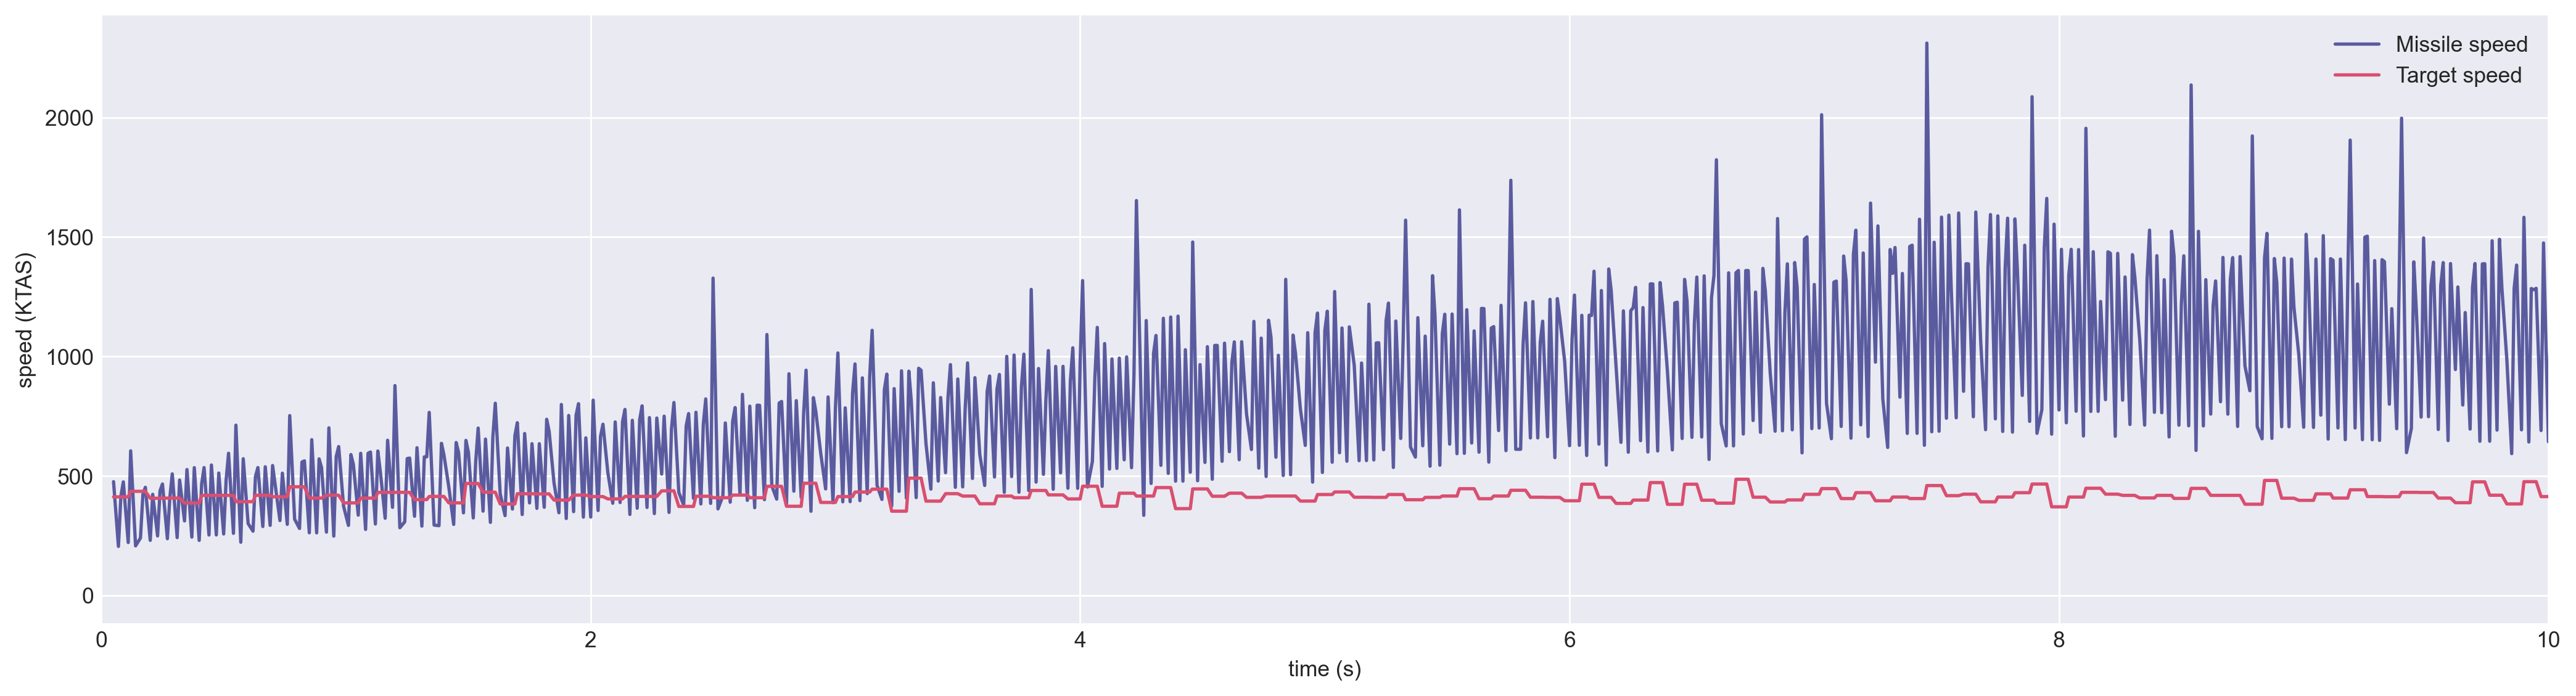

In [5]:
dx = msl['u'] - tgt['u']
dy = msl['v'] - tgt['v']
dz = msl['alt'] - tgt['alt']
pl.figure(dpi=256, figsize=[20, 5])
pl.plot(msl['time'], np.sqrt(dx*dx + dy*dy + dz*dz))

def speed(d):
    dx = d['u'].diff()
    dy = d['v'].diff()
    dz = d['alt'].diff()
    dt = d['time'].diff()
    return np.sqrt(dx*dx + dy*dy + dz*dz)/dt

pl.figure(dpi=256, figsize=[20, 5])
pl.plot(msl['time'], speed(msl), label='Missile speed')
pl.plot(tgt['time'], speed(tgt), label='Target speed')
pl.xlabel('time (s)')
w
pl.ylabel('speed (KTAS)')
pl.legend()
pl.xlim(0, 10)

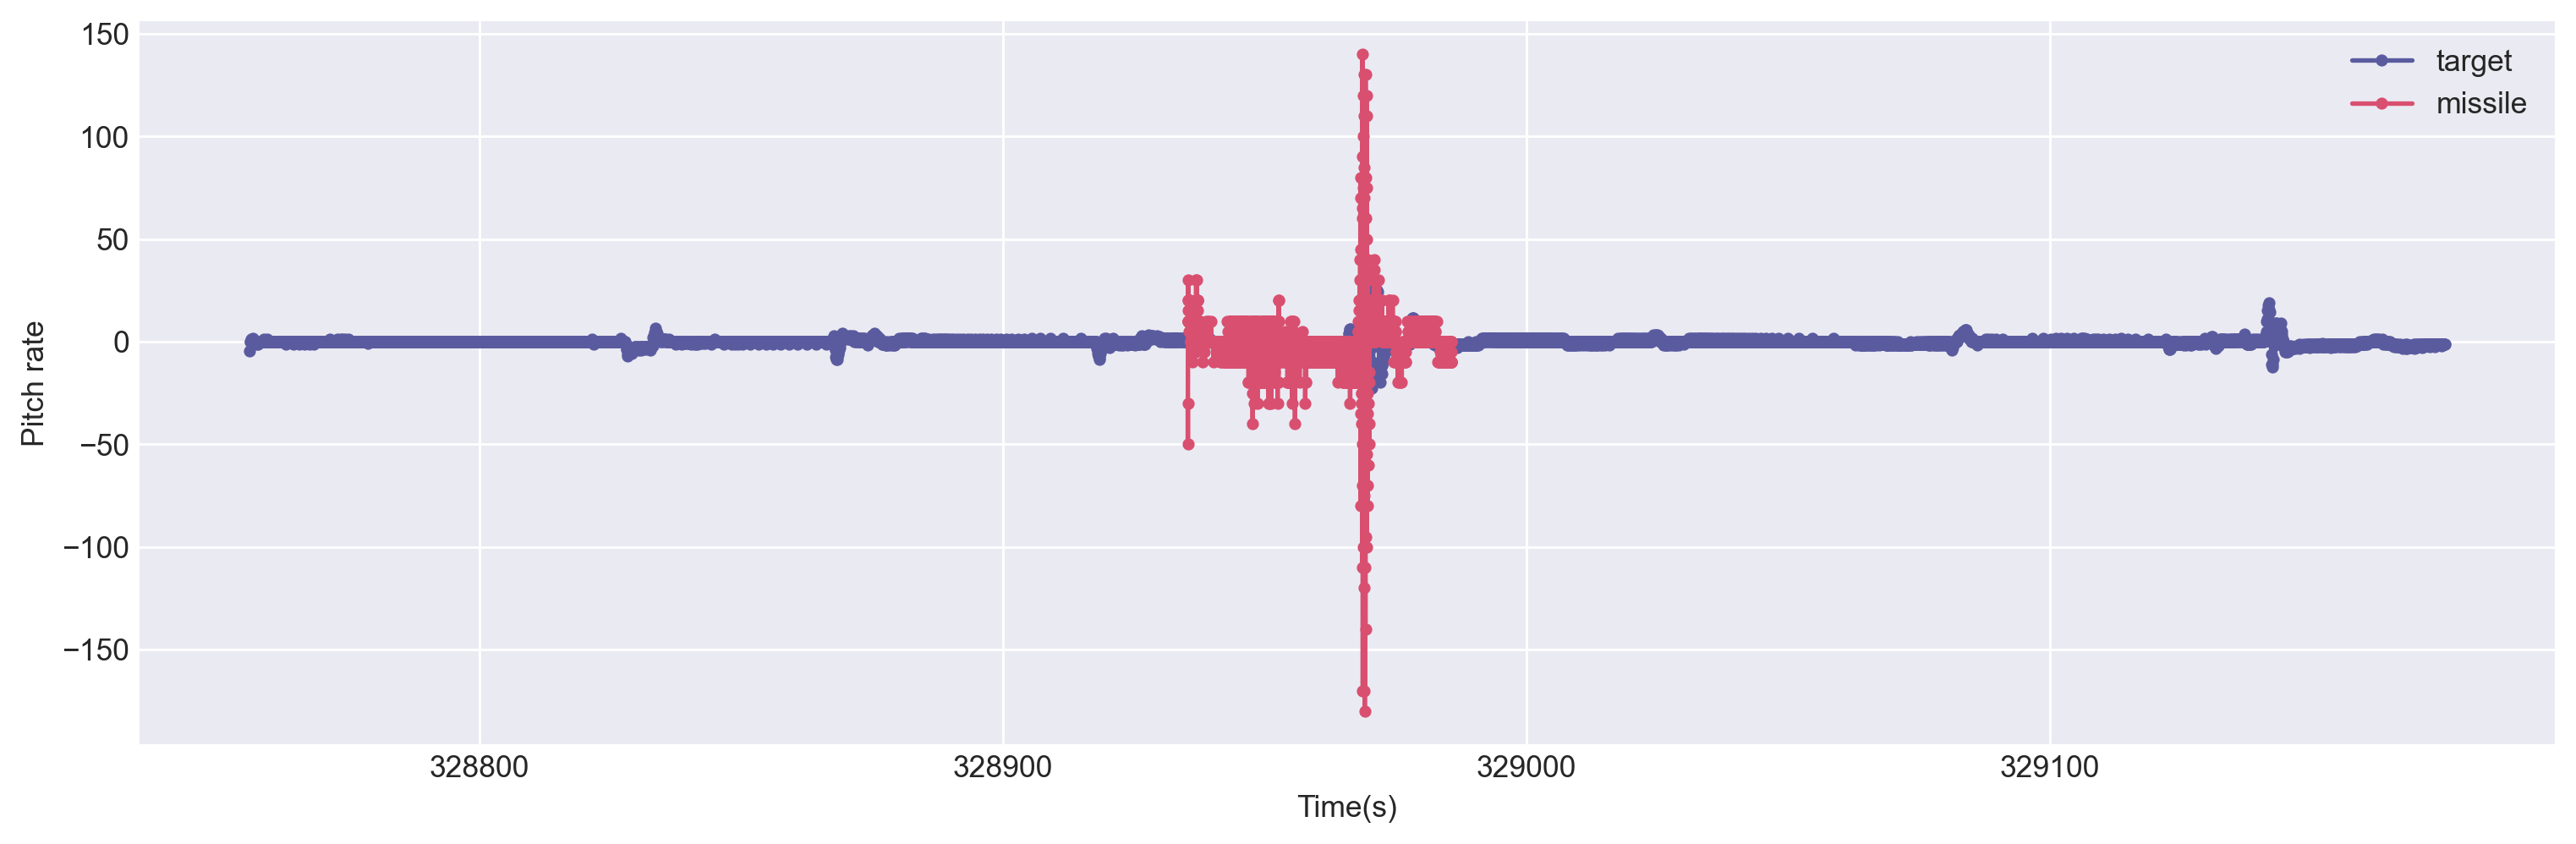

In [4]:
pl.figure(dpi=256, figsize=[12, 4])
pl.plot(tgt_data['time'], tgt_data['pitch'].diff()/tgt_data['time'].diff(), '.-', label='target')
pl.plot(missile_data['time'],
        missile_data['pitch'].diff() / missile_data['time'].diff(),
        '.-',
        label='missile')
pl.legend()
pl.xlabel('Time(s)')
pl.ylabel('Pitch rate')
pl.tight_layout()